In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.stats import *
import os
from matplotlib import pyplot as plt
import seaborn as sns
from copy import copy
import sys
sys.path.append('/stanley/WangLab/Connie/02.TEMPOmap/03.revision1000Gene/code')
from helper import *

### input

In [2]:
ppath = '/stanley/WangLab/Connie/02.TEMPOmap/03.revision1000Gene'
adata = sc.read_h5ad(os.path.join(ppath, 'adata', '2022-10-21-TEMPOrevision1000Gene-filtered.h5ad'))
adata

AnnData object with n_obs × n_vars = 14359 × 998
    obs: 'orig_index', 'sample', 'volume', 'x', 'y', 'z', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'Fluo', 'mKO2', 'mKO', 'mAG', 'nuclei_volume', 'sc_norm_total_wo_anchor', 'nucl_pct', 'filter_cell_vol', 'filter_nucl_vol', 'filter_counts', 'filter'

In [3]:
sample_list = np.unique(adata.obs['sample'])
n_samples = len(sample_list)
sample_list

array(['1h_labeling', '1h_labeling_1h_wash', '1h_labeling_2h_wash',
       '1h_labeling_4h_wash', '1h_labeling_6h_wash', '20h_labeling',
       'STARmap'], dtype=object)

In [4]:
# anchor genes
_anchor = pd.read_csv(os.path.join(ppath, '1000-gene HeLa dataset anchor gene.csv'))
anchor = _anchor['Anchor gene'].values
anchor

array(['YTHDF1', 'YTHDF2', 'YTHDF3', 'YTHDC1', 'YTHDC2', 'METTL14',
       'METTL3'], dtype=object)

## cc_marker expression

### import marker

In [5]:
# Load markers 
ppath = '/stanley/WangLab/Connie/02.TEMPOmap/03.revision1000Gene'
s_genes = pd.read_excel(os.path.join(ppath, 'cell_cycle_markers.xlsx'), sheet_name='G1_S', header=None)[0].to_list()
g2m_genes = pd.read_excel(os.path.join(ppath, 'cell_cycle_markers.xlsx'), sheet_name='G2_M', header=None)[0].to_list()
cell_cycle_genes = s_genes + g2m_genes

In [6]:
# Get cell cycle genes 
missed_genes = [x for x in cell_cycle_genes if x not in adata.var_names]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
s_genes_true = [x for x in s_genes if x in adata.var_names]
g2m_genes_true = [x for x in g2m_genes if x in adata.var_names]

print('cell cycle genes: ', len(cell_cycle_genes), '\nmissed genes: ', len(missed_genes))
print(f"G1/S genes: {len(s_genes)} - G2/M genes: {len(g2m_genes)}")
print(f"G1/S genes in our dataest: {len(s_genes_true)} - G2/M genes in our dataest: {len(g2m_genes_true)}")

cell cycle genes:  41 
missed genes:  0
G1/S genes: 19 - G2/M genes: 22
G1/S genes in our dataest: 19 - G2/M genes in our dataest: 22


### alternative marker set

In [50]:
# selected high expr marker
ccmk = pd.read_excel(os.path.join(ppath, 'cell_cycle_marker_selected.xlsx'), index_col=0)
g1_s = ccmk[ccmk['G1_S'] == 'G1_S'].index.tolist()
g2_m = ccmk[ccmk['G2_M'] == 'G2_M'].index.tolist()
cc_selected = g1_s + g2_m

In [46]:
# remove CCNF (highest expr)
g2_m_ = g2_m[1:]
cc_selected_ = g1_s + g2_m_

In [59]:
# selected high expr marker-2
ccmk2 = ccmk[:17]
g1_s2 = ccmk2[ccmk2['G1_S'] == 'G1_S'].index.tolist()
g2_m2 = ccmk2[ccmk2['G2_M'] == 'G2_M'].index.tolist()
cc_selected2 = g1_s2 + g2_m2

In [12]:
# m6A marker
cc_markers = pd.read_excel('/stanley/WangLab/Data/Processed/2022-04-14-m6A-100-gene/20220713_m6A_100_gene_cell_cycle_marker.xlsx')
s_genes = [cc_markers.iloc[i]['Gene_name'] for i in range(len(cc_markers)) if cc_markers.iloc[i]['Cell_cycle'].endswith('G1/S')]
g2m_genes = [cc_markers.iloc[i]['Gene_name'] for i in range(len(cc_markers)) if cc_markers.iloc[i]['Cell_cycle'].endswith('G2/M')]
cc_genes = s_genes + g2m_genes

### marker gene expression

In [11]:
adata.layers['raw'] = adata.X
sc.pp.normalize_total(adata, target_sum=1e4)

In [22]:
# df = pd.DataFrame(adata[:, cell_cycle_genes].X, columns=cell_cycle_genes)
# df = pd.concat((df.reset_index(), adata.obs['sample'].reset_index()), axis=1)
# df

index    BCL2L1      CDC6     DSCC1       DTL      MCM5       UNG  \
0          0 -0.672744 -0.362928 -0.348745 -0.504642 -0.262595 -0.141576   
1          1 -0.672744 -0.362928 -0.348745 -0.504642 -0.262595 -0.141576   
2          2 -0.672744 -0.362928 -0.348745 -0.504642 -0.262595 -0.141576   
3          3 -0.672744 -0.362928 -0.348745 -0.504642 -0.262595 -0.141576   
4          4 -0.672744 -0.362928 -0.348745 -0.504642 -0.262595 -0.141576   
...      ...       ...       ...       ...       ...       ...       ...   
14354  14354  0.730593  1.931402  2.109902  1.654835 -0.262595 -0.141576   
14355  14355 -0.672744 -0.362928 -0.348745  1.754679 -0.262595 -0.141576   
14356  14356  0.692502  1.869126 -0.348745 -0.504642  2.802406 -0.141576   
14357  14357  0.729538 -0.362928 -0.348745  1.193781 -0.262595 -0.141576   
14358  14358  0.990750 -0.362928  2.565696 -0.504642 -0.262595 -0.141576   

            SNN      FEN1     GINS2  ...     HMGB2    NCAPD2     NDC80  \
0     -0.168807 -0.123714 -0.518950  ... -0.402181 -0.366778 -0.357119   
1     -0.168807 -0.123714 -0.518950  ... -0.402181 -0.366778 -0.357119   
2     -0.168807 -0.123714  2.971263  ... -0.402181  3.478844 -0.357119   
3     -0.168807 -0.123714 -0.518950  ... -0.402181 -0.366778 -0.357119   
4     -0.168807 -0.123714 -0.518950  ... -0.402181 -0.366778 -0.357119   
...         ...       ...       ...  ...       ...       ...       ...   
14354 -0.168807 -0.123714  1.806887  ...  2.373853  1.900553  1.974349   
14355 -0.168807  7.381981 -0.518950  ...  2.502203 -0.366778 -0.357119   
14356  5.388956 -0.123714  1.059527  ...  1.723498 -0.366778  1.911066   
14357 -0.168807 -0.123714  1.541186  ... -0.402181 -0.366778  1.972595   
14358  6.603086 -0.123714  1.404356  ... -0.402181  2.950389 -0.357119   

           NUF2     TACC3      TMPO     MKI67     CENPF  index  \
0     -0.452716 -0.305928 -0.250571 -0.501363 -0.404275      0   
1     -0.452716 -0.305928 -0.250571 -0.501363 -0.404275      1   
2      2.766966 -0.305928 -0.250571 -0.501363 -0.404275      2   
3     -0.452716 -0.305928 -0.250571 -0.501363 -0.404275      4   
4     -0.452716 -0.305928 -0.250571 -0.501363 -0.404275      5   
...         ...       ...       ...       ...       ...    ...   
14354  1.445569 -0.305928 -0.250571  1.624579 -0.404275  17742   
14355 -0.452716 -0.305928 -0.250571  2.579167 -0.404275  17743   
14356 -0.452716  2.233024 -0.250571  2.044168 -0.404275  17744   
14357  1.444141 -0.305928 -0.250571  2.091710 -0.404275  17745   
14358  1.797480 -0.305928 -0.250571  2.223620 -0.404275  17747   

                    sample  
0      1h_labeling_2h_wash  
1      1h_labeling_2h_wash  
2      1h_labeling_2h_wash  
3      1h_labeling_2h_wash  
4      1h_labeling_2h_wash  
...                    ...  
14354              STARmap  
14355              STARmap  
14356              STARmap  
14357              STARmap  
14358              STARmap  

[14359 rows x 44 columns]

<AxesSubplot:xlabel='cc_marker', ylabel='mean_norm_total'>

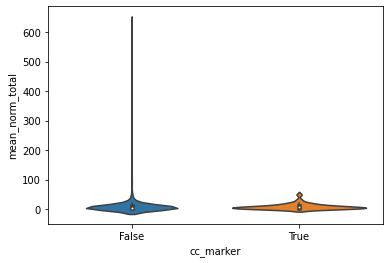

In [11]:
adata.var['mean_norm_total'] = np.mean(adata.X, axis=0)
adata.var['cc_marker'] = np.isin(adata.var_names, cell_cycle_genes)
sns.violinplot(data=adata.var, x='cc_marker', y='mean_norm_total')

In [13]:
# gene expression in different sample
sample_mean_expr = dict()
for sample in sample_list:
    expr = adata.X[adata.obs['sample']==sample]
    mean_expr = np.mean(expr, axis=0)
    sample_mean_expr[sample] = mean_expr

In [20]:
df = pd.DataFrame.from_dict(sample_mean_expr)
df['cc_marker'] = np.isin(adata.var_names, cell_cycle_genes)
df.index=adata.var_names
df

1h_labeling  1h_labeling_1h_wash  1h_labeling_2h_wash  \
METTL14    62.550827            68.179245           111.817329   
METTL3    122.486153           132.121567           165.981094   
YTHDC1    464.951111           442.565247           733.880371   
YTHDC2      0.126052             0.350472             0.171963   
YTHDF1    140.032898           189.268661           354.835205   
...              ...                  ...                  ...   
ZRANB1      5.066823             3.349685             3.568827   
ZSCAN12     0.289741             0.697579             0.625341   
ZSCAN29     3.316659             4.116669             2.686750   
ZXDC        5.541586             6.157182             4.425200   
ZYG11A      5.568449             6.113801             3.926032   

         1h_labeling_4h_wash  1h_labeling_6h_wash  20h_labeling    STARmap  \
METTL14           128.304184           199.179077     20.500452   5.496850   
METTL3            206.247162           272.190430     31.524759  13.128798   
YTHDC1            815.013611          1099.568726    168.508530  29.777586   
YTHDC2              0.329177             0.211423      0.729490   0.989927   
YTHDF1            443.058807           639.638123     35.199303   8.382226   
...                      ...                  ...           ...        ...   
ZRANB1              4.529316             1.915308      4.814207   6.450081   
ZSCAN12             0.538208             0.367267      0.781056   0.896672   
ZSCAN29             2.232736             1.616059      2.810503   2.759580   
ZXDC                4.177005             3.593983      5.903209   8.800767   
ZYG11A              2.414422             2.184251      4.870407   8.661440   

         cc_marker  
METTL14      False  
METTL3       False  
YTHDC1       False  
YTHDC2       False  
YTHDF1       False  
...            ...  
ZRANB1       False  
ZSCAN12      False  
ZSCAN29      False  
ZXDC         False  
ZYG11A       False  

[998 rows x 8 columns]

In [21]:
# df.to_csv('expr_by_sample.csv')

### scoring

In [10]:
# plt.style.use('dark_background')

/stanley/WangLab/envs/connie_TR/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


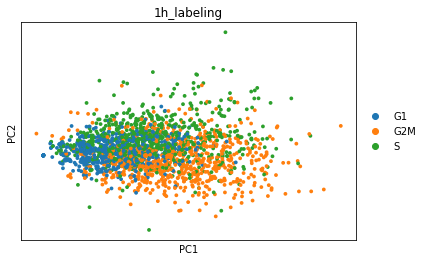

/stanley/WangLab/envs/connie_TR/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


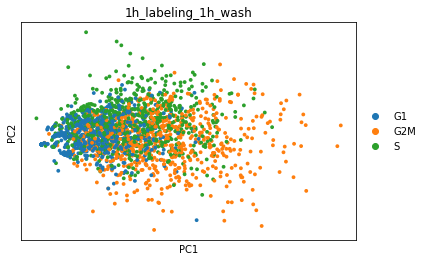

/stanley/WangLab/envs/connie_TR/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


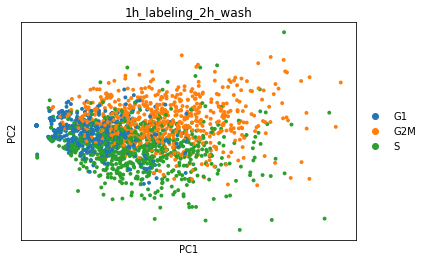

/stanley/WangLab/envs/connie_TR/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


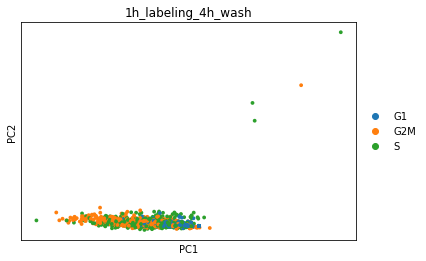

/stanley/WangLab/envs/connie_TR/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


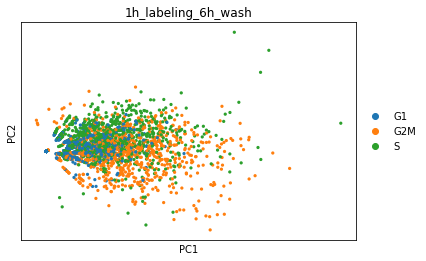

/stanley/WangLab/envs/connie_TR/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


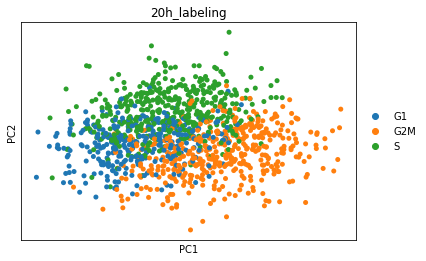

/stanley/WangLab/envs/connie_TR/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


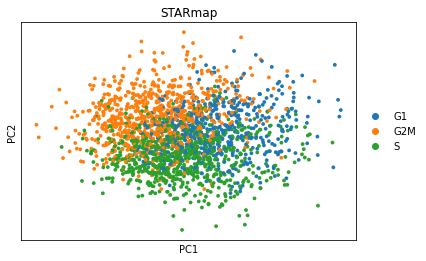

In [7]:
# score cc for each sample
sample_adata = dict()
anchor_means = dict()

for sample in sample_list:
    _adata = separate_adata_by_sample(adata, sample)
    _adata.layers['raw_counts'] = _adata.X
    # normalize each sample by average of the anchor gene # NOTE doesn't matter actually
    anchor_expr = _adata.X[:, np.isin(adata.var.index, anchor)]
    anchor_mean = np.average(anchor_expr)
    anchor_means[sample] = anchor_mean
    anchor_normalized_X = _adata.X / anchor_mean
    _adata.layers['anchor_normalized_expr'] = anchor_normalized_X
    # preprocess
    _adata_ = _adata[:,np.isin(adata.var.index, anchor, invert=True)]
    sc.pp.normalize_total(_adata_, target_sum=1e4)
    # add marker gene mean expression to obs
    for g in cell_cycle_genes:
        _adata_.obs[g] = _adata_.X[:, _adata_.var.index==g]
    sc.pp.log1p(_adata_)
    sc.pp.scale(_adata_)
    # Compute gene set score
    sc.tl.score_genes_cell_cycle(_adata_, s_genes=s_genes, g2m_genes=g2m_genes, n_bins=10)
    adata_cc_genes = _adata_[:, cell_cycle_genes]
    sc.tl.pca(adata_cc_genes)
    sc.pl.pca_scatter(adata_cc_genes, color='phase', title=f'{sample}')
    # add to dict
    sample_adata[sample] = _adata_
    # save a copy of adata by sample 
    # _adata_.write_h5ad(os.path.join(ppath, 'adata', f'TEMPO-1000gene-flt-{sample}.h5ad'))
    # break

### alternative scoring

/stanley/WangLab/envs/connie_TR/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


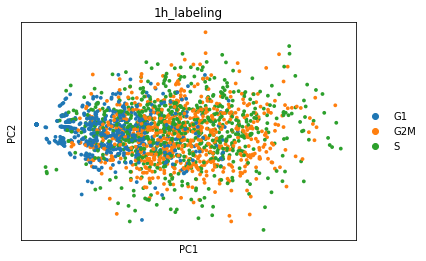

/stanley/WangLab/envs/connie_TR/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


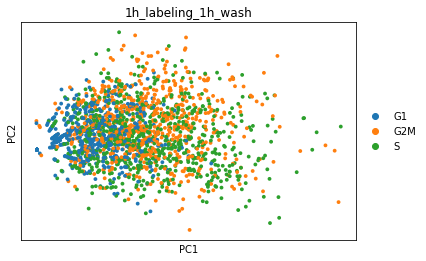

/stanley/WangLab/envs/connie_TR/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


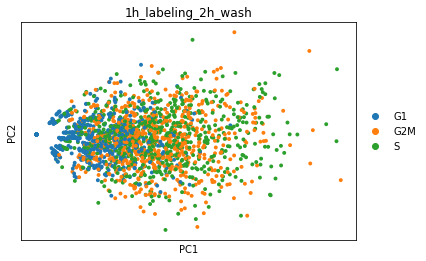

/stanley/WangLab/envs/connie_TR/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


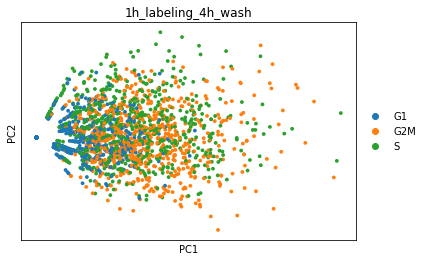

/stanley/WangLab/envs/connie_TR/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


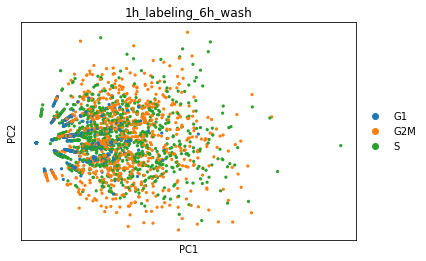

/stanley/WangLab/envs/connie_TR/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


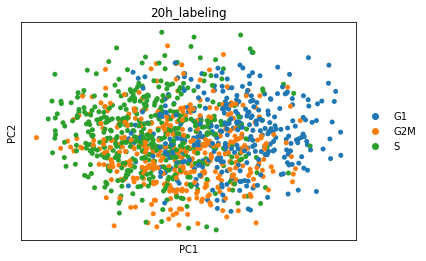

/stanley/WangLab/envs/connie_TR/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


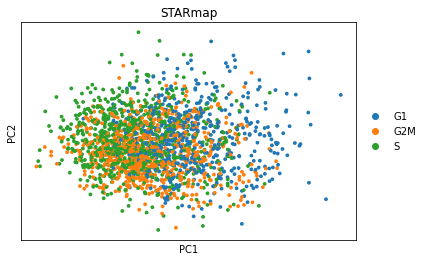

In [51]:
# score using selected high expr marker
for sample in sample_list:
    _adata = separate_adata_by_sample(adata, sample)
    _adata.layers['raw_counts'] = _adata.X
    # preprocess
    _adata_ = _adata[:,np.isin(adata.var.index, anchor, invert=True)]
    sc.pp.normalize_total(_adata_, target_sum=1e4)
    sc.pp.log1p(_adata_)
    sc.pp.scale(_adata_)
    # Compute gene set score
    sc.tl.score_genes_cell_cycle(_adata_, s_genes=g1_s, g2m_genes=g2_m, n_bins=10)
    adata_cc_genes = _adata_[:, cc_selected]
    sc.tl.pca(adata_cc_genes)
    sc.pl.pca_scatter(adata_cc_genes, color='phase', title=f'{sample}')

/stanley/WangLab/envs/connie_TR/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


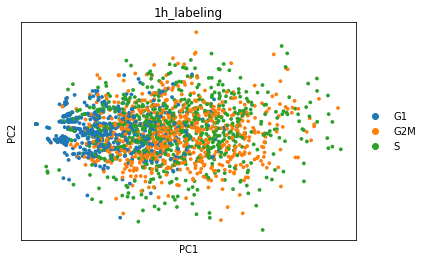

/stanley/WangLab/envs/connie_TR/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


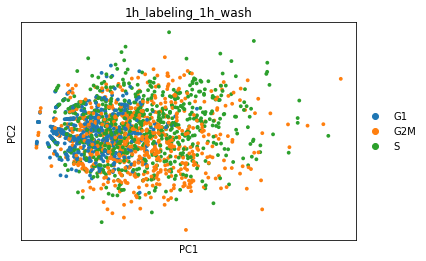

/stanley/WangLab/envs/connie_TR/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


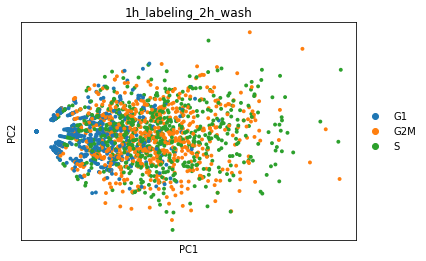

/stanley/WangLab/envs/connie_TR/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


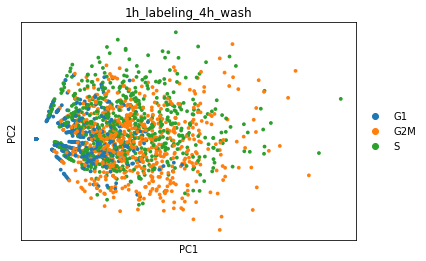

/stanley/WangLab/envs/connie_TR/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


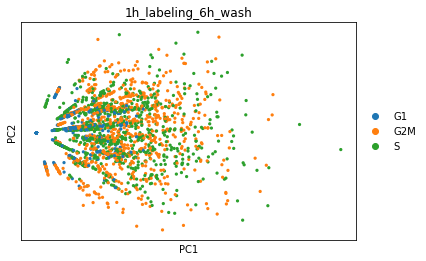

/stanley/WangLab/envs/connie_TR/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


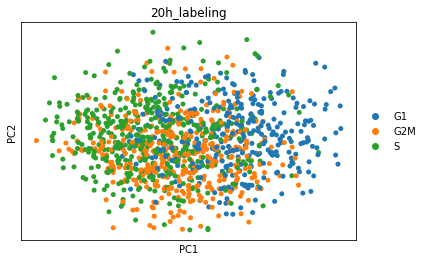

/stanley/WangLab/envs/connie_TR/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


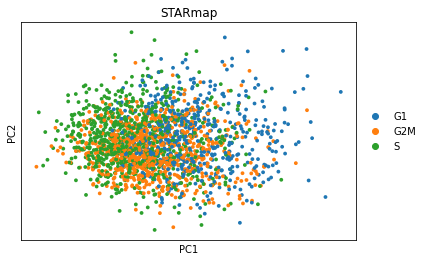

In [56]:
# score using selected high expr marker (remove CCNF)
for sample in sample_list:
    _adata = separate_adata_by_sample(adata, sample)
    _adata.layers['raw_counts'] = _adata.X
    # preprocess
    _adata_ = _adata[:,np.isin(adata.var.index, anchor, invert=True)]
    sc.pp.normalize_total(_adata_, target_sum=1e4)
    sc.pp.log1p(_adata_)
    sc.pp.scale(_adata_)
    # Compute gene set score
    sc.tl.score_genes_cell_cycle(_adata_, s_genes=g1_s, g2m_genes=g2_m_, n_bins=10)
    adata_cc_genes = _adata_[:, cc_selected_]
    sc.tl.pca(adata_cc_genes)
    sc.pl.pca_scatter(adata_cc_genes, color='phase', title=f'{sample}')

/stanley/WangLab/envs/connie_TR/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


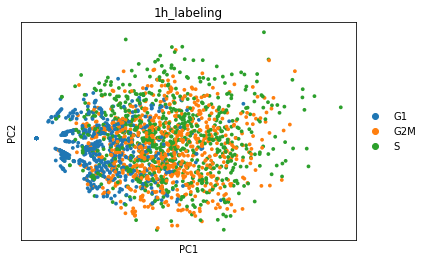

/stanley/WangLab/envs/connie_TR/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


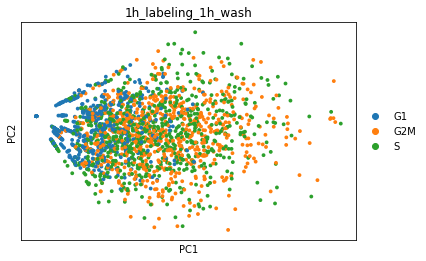

/stanley/WangLab/envs/connie_TR/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


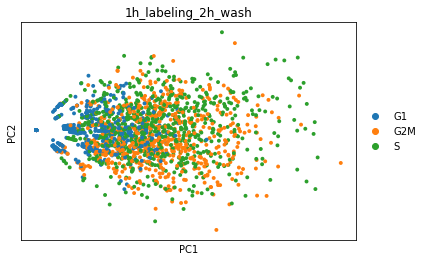

/stanley/WangLab/envs/connie_TR/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


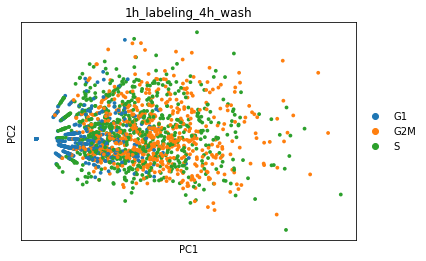

/stanley/WangLab/envs/connie_TR/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


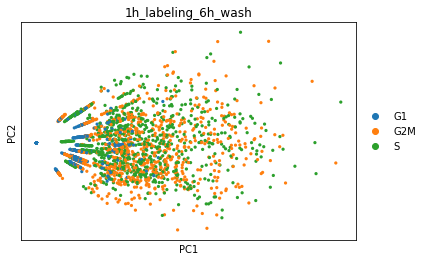

/stanley/WangLab/envs/connie_TR/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


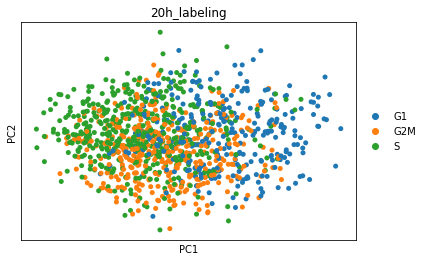

/stanley/WangLab/envs/connie_TR/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


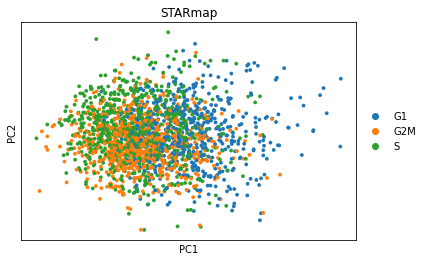

In [63]:
# score using selected high expr marker (remove CCNF)
for sample in sample_list:
    _adata = separate_adata_by_sample(adata, sample)
    # _adata.layers['raw_counts'] = _adata.X
    # preprocess
    _adata_ = _adata[:,np.isin(adata.var.index, anchor, invert=True)]
    sc.pp.normalize_total(_adata_, target_sum=1e4)
    sc.pp.log1p(_adata_)
    sc.pp.scale(_adata_)
    # Compute gene set score
    sc.tl.score_genes_cell_cycle(_adata_, s_genes=g1_s2, g2m_genes=g2_m2, n_bins=10)
    adata_cc_genes = _adata_[:, cc_selected2]
    sc.tl.pca(adata_cc_genes)
    sc.pl.pca_scatter(adata_cc_genes, color='phase', title=f'{sample}')

/stanley/WangLab/envs/connie_TR/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


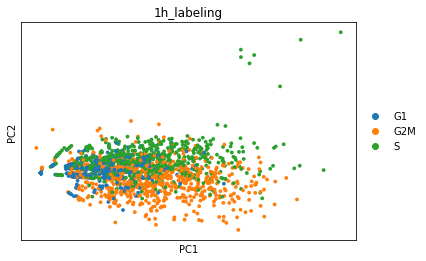

/stanley/WangLab/envs/connie_TR/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


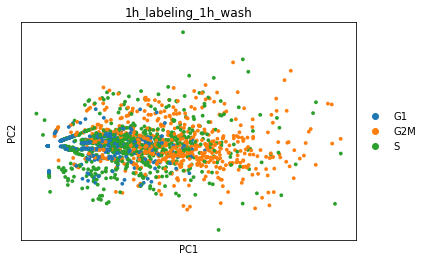

/stanley/WangLab/envs/connie_TR/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


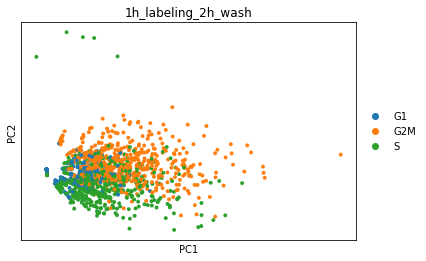

/stanley/WangLab/envs/connie_TR/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


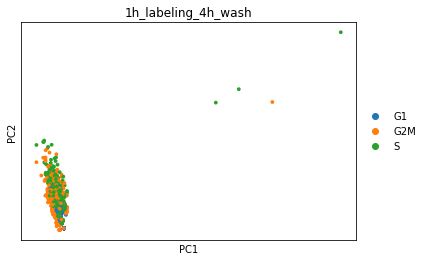

/stanley/WangLab/envs/connie_TR/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


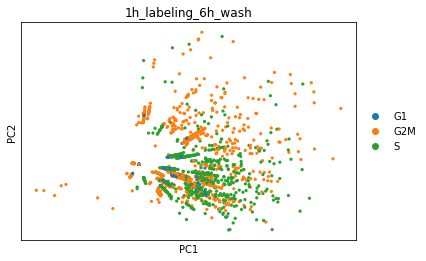

/stanley/WangLab/envs/connie_TR/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


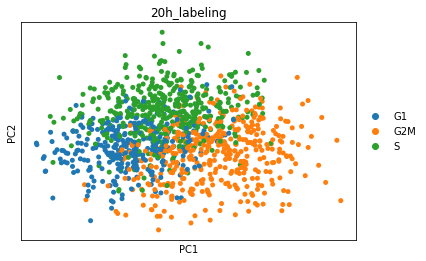

/stanley/WangLab/envs/connie_TR/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


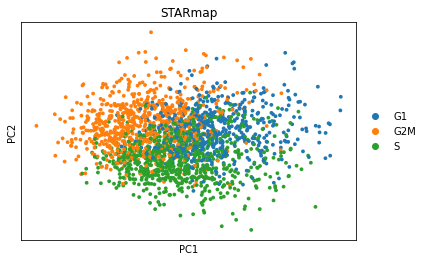

In [13]:
# score using m6A marker
for sample in sample_list:
    _adata = separate_adata_by_sample(adata, sample)
    # _adata.layers['raw_counts'] = _adata.X
    # preprocess
    _adata_ = _adata[:,np.isin(adata.var.index, anchor, invert=True)]
    sc.pp.normalize_total(_adata_, target_sum=1e4)
    sc.pp.log1p(_adata_)
    sc.pp.scale(_adata_)
    # Compute gene set score
    sc.tl.score_genes_cell_cycle(_adata_, s_genes=s_genes, g2m_genes=g2m_genes, n_bins=10)
    adata_cc_genes = _adata_[:, cc_genes]
    sc.tl.pca(adata_cc_genes)
    sc.pl.pca_scatter(adata_cc_genes, color='phase', title=f'{sample}')

### troubleshoot 1h_4h

In [12]:
sample_list

array(['1h_labeling', '1h_labeling_1h_wash', '1h_labeling_2h_wash',
       '1h_labeling_4h_wash', '1h_labeling_6h_wash', '20h_labeling',
       'STARmap'], dtype=object)

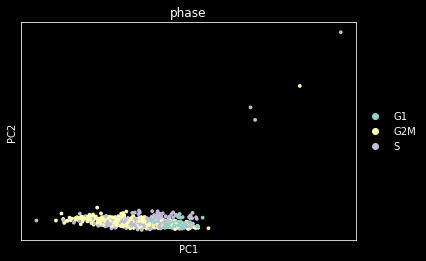

In [18]:
adata_1h4h = sample_adata['1h_labeling_4h_wash']
adata_1h4h_cc = adata_1h4h[:, cell_cycle_genes]
sc.tl.pca(adata_1h4h_cc)
sc.pl.pca_scatter(adata_1h4h_cc, color='phase')

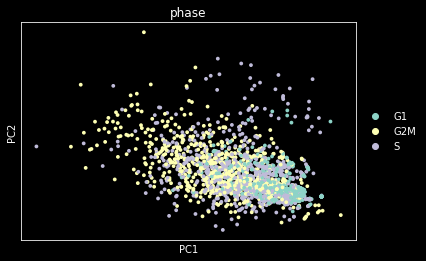

In [33]:
sc.pl.pca_scatter(adata_1h4h_cc[adata_1h4h_cc.obsm['X_pca'][:, 1] < 10], color='phase')

In [ ]:
# normalize by batch anchor average
total_batch_norm = []
for sample in sample_list:
    total_batch_norm.extend(list(np.sum(sample_adata[sample].layers['anchor_normalized_expr'][:, np.isin(adata.var.index, anchor, invert=True)], axis=1)))
_df = pd.DataFrame(zip(list(adata.obs['sample'].values), total_batch_norm), columns=['sample', 'total_batch_norm'])
_df

In [ ]:
sns.violinplot(data=_df, x='sample', y='total_batch_norm')
plt.xticks(rotation=45)

### check cc label with image

In [84]:
# choose cell of to check
sample = 'STARmap'
obs = sample_adata[sample].obs
obs

orig_index   sample  volume      x      y   z  n_genes_by_counts  \
15146           2  STARmap  508222     56  11360  15                357   
15148           4  STARmap  252111     48   1118   9                340   
15153           9  STARmap  263381     52   8794  11                295   
15154          10  STARmap  260529     37   2442  10                286   
15156          12  STARmap  464291     57   3715  10                419   
...           ...      ...     ...    ...    ...  ..                ...   
17742        2598  STARmap  585749  18456   1722  19                497   
17743        2599  STARmap  619667  18457   4388  17                440   
17744        2600  STARmap  610088  18443   3161  15                512   
17745        2601  STARmap  533619  18465   4627  16                473   
17747        2603  STARmap  347289  18477   9043  16                361   

       log1p_n_genes_by_counts  total_counts  log1p_total_counts  ...  \
15146                 5.880533         612.0            6.418365  ...   
15148                 5.831882         554.0            6.318968  ...   
15153                 5.690359         461.0            6.135565  ...   
15154                 5.659482         418.0            6.037871  ...   
15156                 6.040255         804.0            6.690842  ...   
...                        ...           ...                 ...  ...   
17742                 6.210600        1010.0            6.918695  ...   
17743                 6.089045         872.0            6.771935  ...   
17744                 6.240276        1085.0            6.990256  ...   
17745                 6.161207        1012.0            6.920671  ...   
17747                 5.891644         626.0            6.440947  ...   

       nuclei_volume  sc_norm_total_wo_anchor  nucl_pct  filter_cell_vol  \
15146         212886              1064.000000  0.274671             True   
15148          96081               639.333435  0.260949             True   
15153         101976              1068.665527  0.331878             True   
15154         126391              1455.999878  0.350962             True   
15156         126205              1400.000000  0.200000             True   
...              ...                      ...       ...              ...   
17742         207900              1003.000000  0.333998             True   
17743         176480              1010.334534  0.249423             True   
17744          99645              1512.003906  0.163889             True   
17745          94551              1173.667114  0.118290             True   
17747          70002               869.400635  0.135266             True   

       filter_nucl_vol  filter_counts  filter   S_score  G2M_score  phase  
15146             True           True    True  0.286966   0.428247    G2M  
15148             True           True    True  0.442608  -0.090456      S  
15153             True           True    True  0.380590  -0.136792      S  
15154             True           True    True -0.238757  -0.153455     G1  
15156             True           True    True -0.531575   0.064729    G2M  
...                ...            ...     ...       ...        ...    ...  
17742             True           True    True  0.469660  -0.013102      S  
17743             True           True    True  0.455821   0.060711      S  
17744             True           True    True -0.257693  -0.244517     G1  
17745             True           True    True  0.442224   0.278148      S  
17747             True           True    True -0.640834  -0.725171     G1  

[2089 rows x 24 columns]

In [121]:
obs[230:250]

orig_index   sample   volume     x      y   z  n_genes_by_counts  \
15439         295  STARmap   638120  1716   9671  14                475   
15440         296  STARmap   415302  1714  10884  12                367   
15441         297  STARmap  1131123  1756   4031  11                616   
15442         298  STARmap  1149491  1694   2061  14                648   
15444         300  STARmap   950369  1747   8093  13                594   
15445         301  STARmap   339368  1760   9936  14                302   
15446         302  STARmap   501938  1772   4280   9                472   
15447         303  STARmap   358950  1728   4593   8                393   
15448         304  STARmap   501321  1736  11466  14                452   
15449         305  STARmap   503703  1732   5413   9                455   
15451         307  STARmap   802778  1754  12959  13                584   
15452         308  STARmap   673700  1761   7848  11                493   
15453         309  STARmap   398288  1748   5005  12                394   
15454         310  STARmap   740359  1772   8816  12                511   
15456         312  STARmap   490051  1767   4874  12                396   
15457         313  STARmap   991510  1779  10230  16                570   
15458         314  STARmap   915836  1776  10615  16                565   
15459         315  STARmap   699010  1765   7072  11                525   
15460         316  STARmap   893544  1737   6247  10                614   
15461         317  STARmap   661848  1790   5557   9                554   

       log1p_n_genes_by_counts  total_counts  log1p_total_counts  ...  \
15439                 6.165418         952.0            6.859615  ...   
15440                 5.908083         625.0            6.439351  ...   
15441                 6.424869        1807.0            7.499977  ...   
15442                 6.475433        1805.0            7.498870  ...   
15444                 6.388561        1445.0            7.276556  ...   
15445                 5.713733         478.0            6.171700  ...   
15446                 6.159095         937.0            6.843750  ...   
15447                 5.976351         698.0            6.549651  ...   
15448                 6.115892         865.0            6.763885  ...   
15449                 6.122493         924.0            6.829794  ...   
15451                 6.371612        1420.0            7.259116  ...   
15452                 6.202536        1056.0            6.963190  ...   
15453                 5.978886         682.0            6.526495  ...   
15454                 6.238325        1164.0            7.060476  ...   
15456                 5.983936         784.0            6.665684  ...   
15457                 6.347389        1365.0            7.219642  ...   
15458                 6.338594        1311.0            7.179308  ...   
15459                 6.265301        1151.0            7.049255  ...   
15460                 6.421622        1656.0            7.412764  ...   
15461                 6.318968        1267.0            7.145196  ...   

       filter_nucl_vol  filter_counts  filter   S_score  G2M_score  phase  \
15439             True           True    True  0.170500   0.440014    G2M   
15440             True           True    True -0.063178  -0.155161     G1   
15441             True           True    True -0.441236  -0.035069     G1   
15442             True           True    True  0.201129   0.132994      S   
15444             True           True    True  0.115536  -0.195498      S   
15445             True           True    True -0.074567  -1.199592     G1   
15446             True           True    True -0.421737   0.387975    G2M   
15447             True           True    True  0.295433  -0.365932      S   
15448             True           True    True -0.615255  -0.380082     G1   
15449             True           True    True  0.224724  -0.256167      S   
15451             True           True    True  0.0

In [83]:
sample_adata[sample].obs_keys

<bound method AnnData.obs_keys of AnnData object with n_obs × n_vars = 2089 × 991
    obs: 'orig_index', 'sample', 'volume', 'x', 'y', 'z', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'Fluo', 'mKO2', 'mKO', 'mAG', 'nuclei_volume', 'sc_norm_total_wo_anchor', 'nucl_pct', 'filter_cell_vol', 'filter_nucl_vol', 'filter_counts', 'filter', 'S_score', 'G2M_score', 'phase'
    var: 'mean', 'std'
    uns: 'log1p'
    layers: 'raw_counts', 'anchor_normalized_expr'>

In [78]:
# import image (overlay)
import tifffile
from skimage.measure import regionprops
dapi = tifffile.imread(f'/stanley/WangLab/Data/Analyzed/2022-09-06-Rena-TEMPOmap1000GeneHeLa3/{sample}/2D/dapi.tif')
dapi_label = tifffile.imread(f'/stanley/WangLab/Data/Analyzed/2022-09-06-Rena-TEMPOmap1000GeneHeLa3/{sample}/2D/dapi_label.tiff')
mAG = tifffile.imread(f'/stanley/WangLab/Data/Analyzed/2022-09-06-Rena-TEMPOmap1000GeneHeLa3/{sample}/2D/mAG.tif')
mKO = tifffile.imread(f'/stanley/WangLab/Data/Analyzed/2022-09-06-Rena-TEMPOmap1000GeneHeLa3/{sample}/2D/mKO.tif')

(18456, 9046, 18513, 9150)


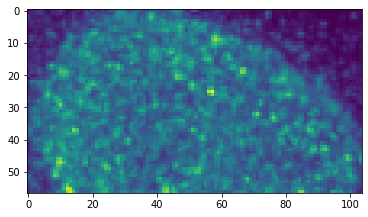

In [116]:
target_idx = 2603
rp = regionprops(dapi_label)
for _ in rp:
    if _.label == target_idx + 1:
        print(_.bbox)
        bbox = _.bbox
plt.imshow(dapi[bbox[0]:bbox[2], bbox[1]:bbox[3]])

17747    70402.0
Name: mAG, dtype: float64

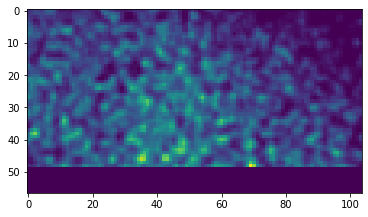

In [117]:
plt.imshow(mAG[bbox[0]:bbox[2], bbox[1]:bbox[3]])
obs[obs['orig_index']==target_idx]['mAG']

17747    1861352.0
Name: mKO, dtype: float64

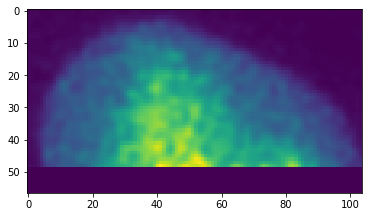

In [118]:
plt.imshow(mKO[bbox[0]:bbox[2], bbox[1]:bbox[3]])
obs[obs['orig_index']==target_idx]['mKO']

In [119]:
# mAG mKO intensity
obs = sample_adata[sample].obs
print(obs[obs['orig_index']==target_idx]['mAG_norm'])
print(obs[obs['orig_index']==target_idx]['mKO_norm'])
print(obs[obs['orig_index']==target_idx]['mAG_zscore'])
print(obs[obs['orig_index']==target_idx]['mKO_zscore'])

17747    1.005714
Name: mAG_norm, dtype: float64
17747    26.589983
Name: mKO_norm, dtype: float64
17747   -0.778958
Name: mAG_zscore, dtype: float64
17747    0.37247
Name: mKO_zscore, dtype: float64


## FUCCI

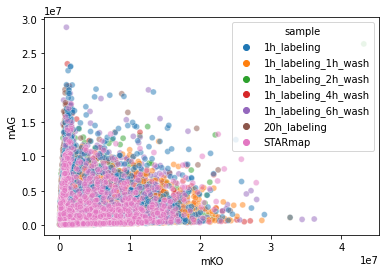

In [14]:
# raw fucci fluorescence
fig = sns.scatterplot(data=adata.obs, x='mKO', y='mAG', hue='sample', alpha=0.5)

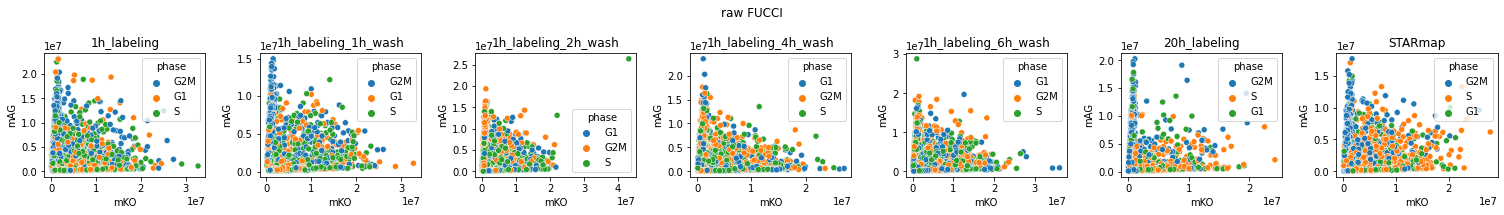

In [23]:
fig, ax = plt.subplots(1, n_samples, figsize=(3*n_samples,3))
for i, sample in enumerate(sample_list):
    sns.scatterplot(data=sample_adata[sample].obs, x='mKO', hue='phase', y='mAG', ax=ax[i]).set_title(sample)
plt.suptitle('raw FUCCI')
plt.tight_layout()

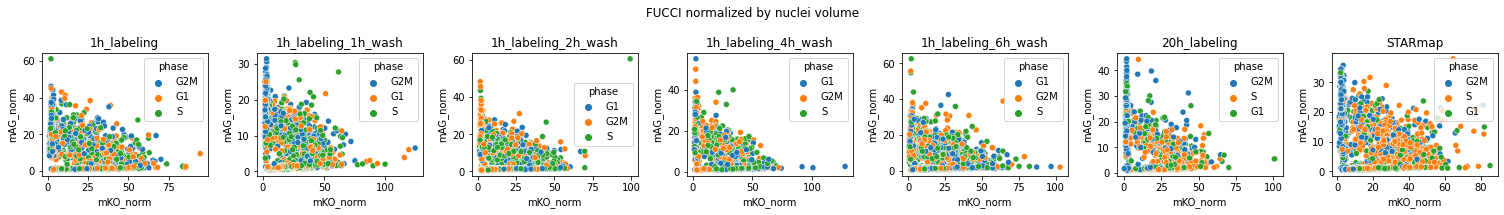

In [8]:
# normalize fucci by nuclei volume
fig, ax = plt.subplots(1, n_samples, figsize=(3*n_samples,3))
for j, sample in enumerate(sample_list):
    obs = copy(sample_adata[sample].obs)
    sample_adata[sample].obs['mKO_norm'] = obs['mKO'] / obs['nuclei_volume']
    sample_adata[sample].obs['mAG_norm'] = obs['mAG'] / obs['nuclei_volume']
    sns.scatterplot(data=sample_adata[sample].obs, x='mKO_norm', y='mAG_norm', hue='phase', ax=ax[j]).set_title(sample)
plt.suptitle('FUCCI normalized by nuclei volume')
plt.tight_layout()

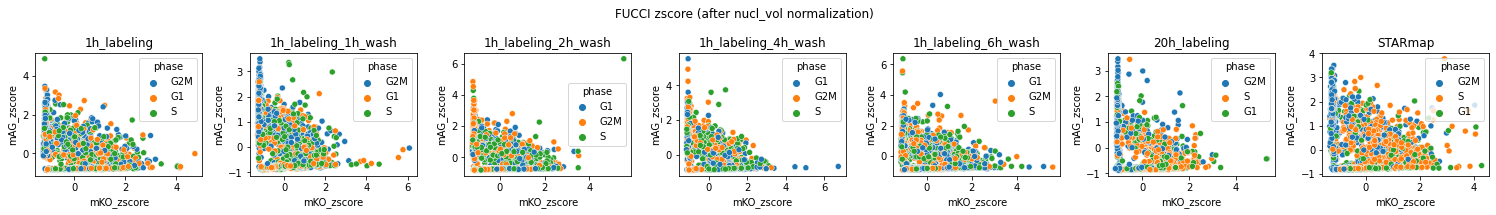

In [9]:
# use z-score
fig, ax = plt.subplots(1, n_samples, figsize=(3*n_samples,3))
for j, sample in enumerate(sample_list):
    obs = copy(sample_adata[sample].obs)
    sample_adata[sample].obs['mKO_zscore'] = zscore(obs['mKO_norm'])
    sample_adata[sample].obs['mAG_zscore'] = zscore(obs['mAG_norm'])
    sns.scatterplot(data=sample_adata[sample].obs, x='mKO_zscore', y='mAG_zscore', hue='phase', ax=ax[j]).set_title(sample)
plt.suptitle('FUCCI zscore (after nucl_vol normalization)')
plt.tight_layout()

## plot cc marker expression on FUCCI

/local/scratch/36923223.1.interactive/ipykernel_80707/2111309210.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, n_samples, figsize=(3*n_samples,3))


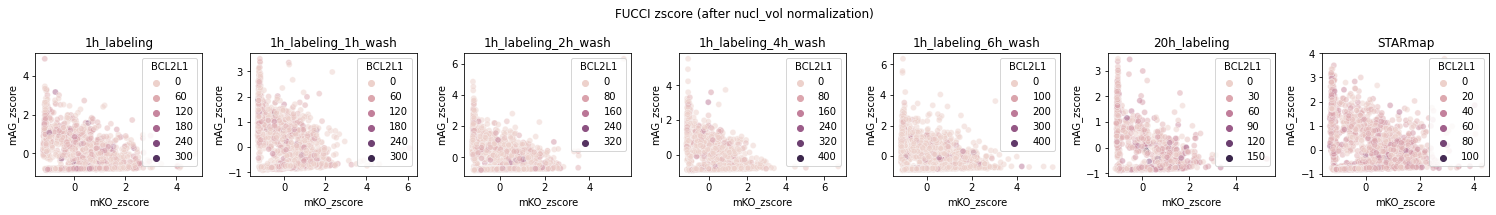

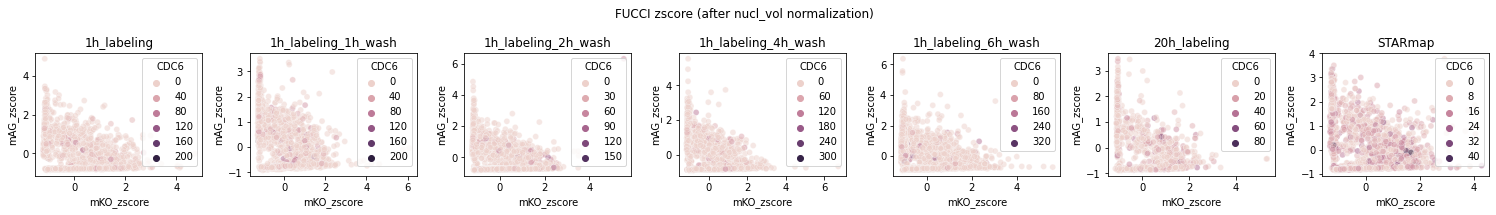

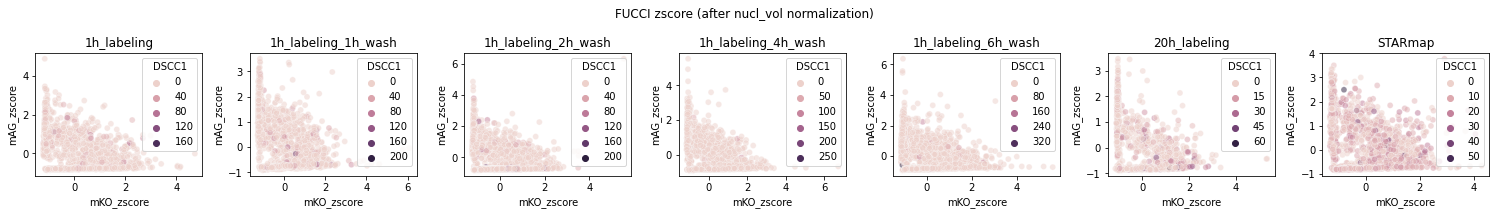

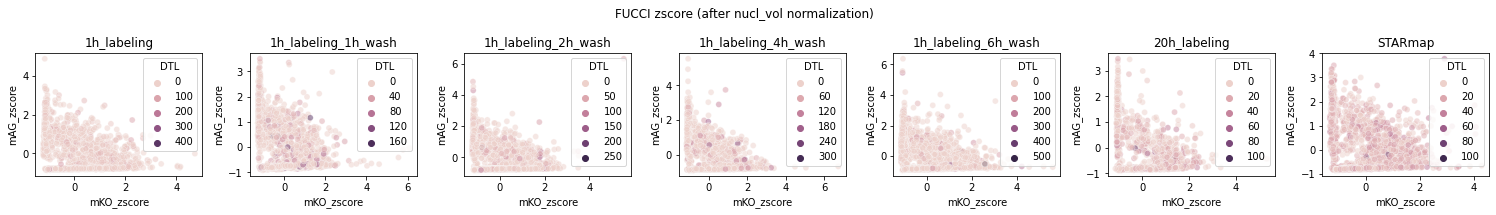

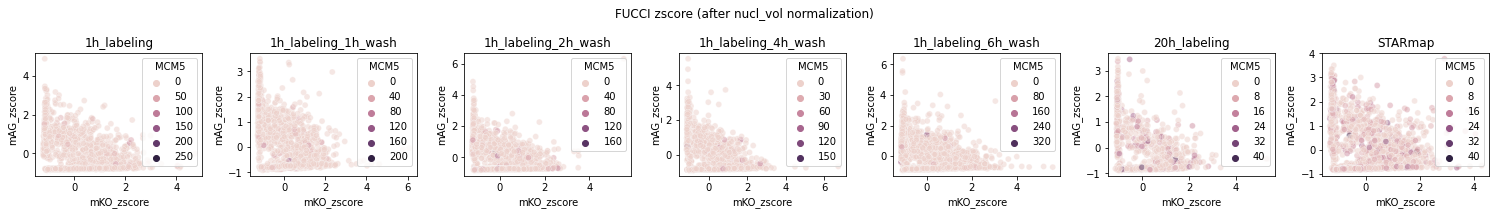

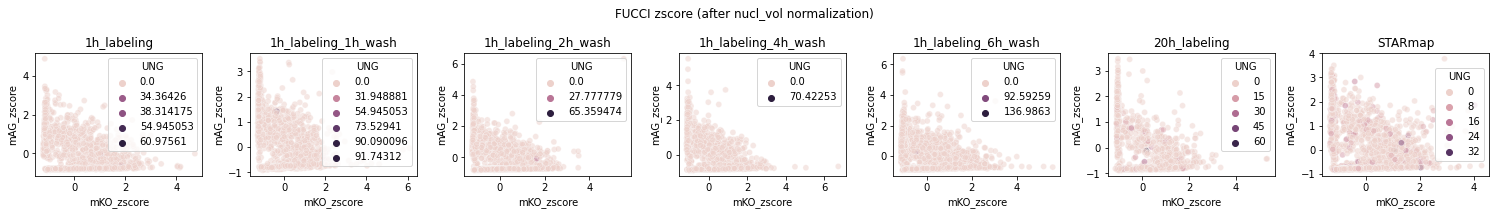

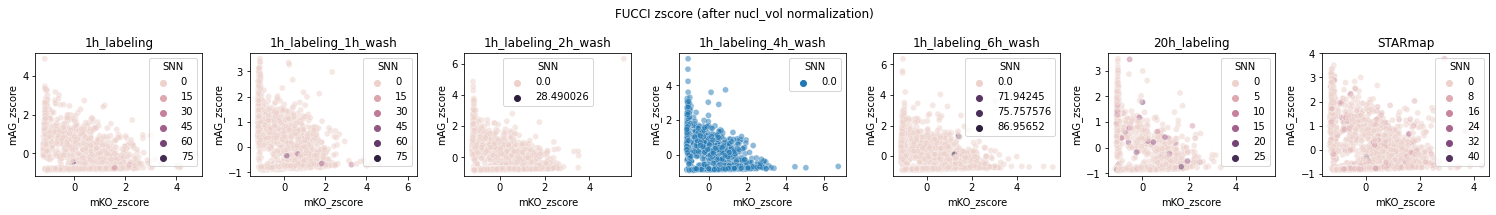

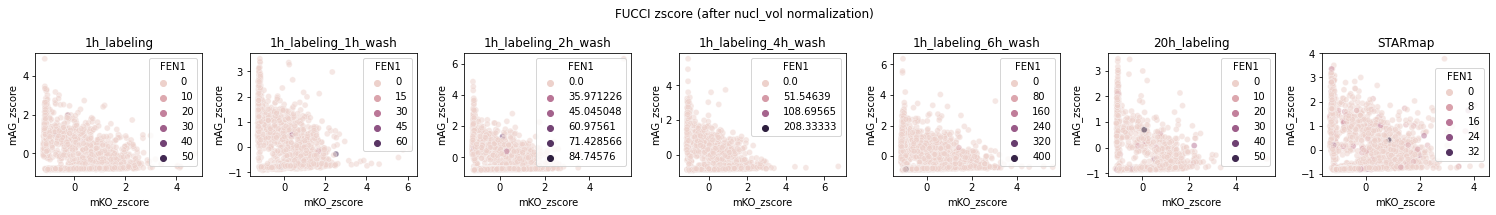

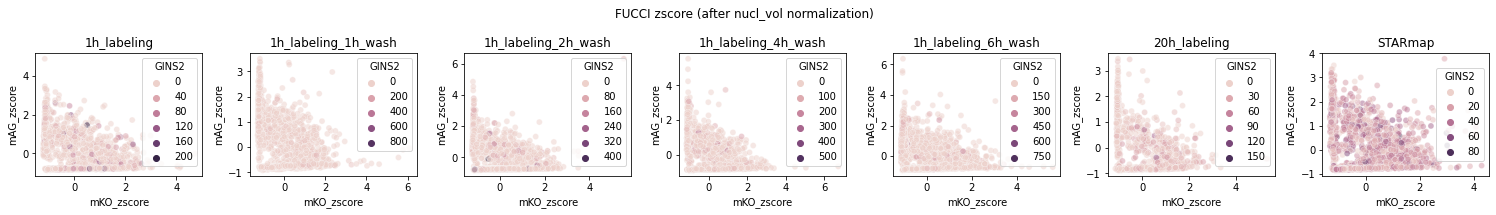

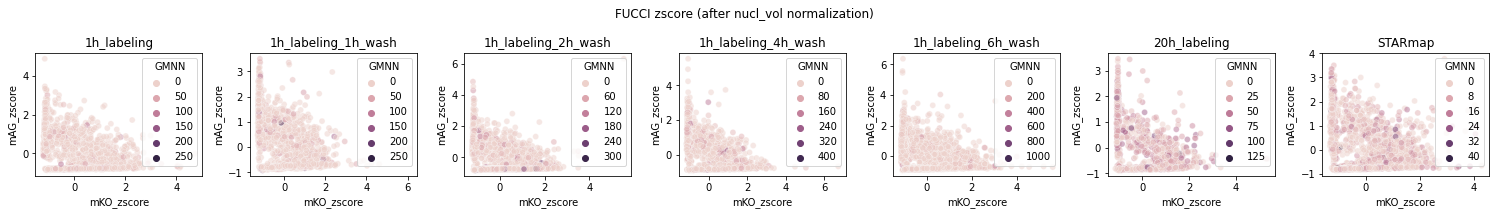

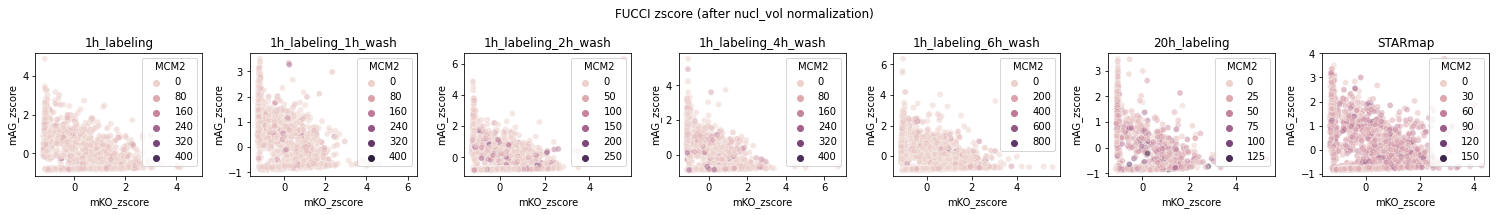

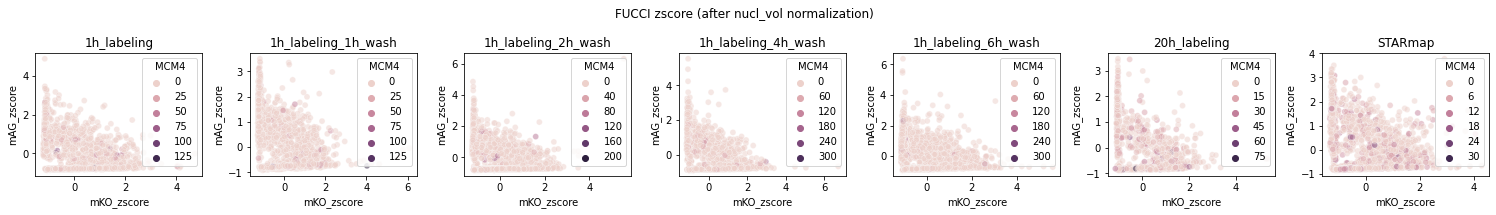

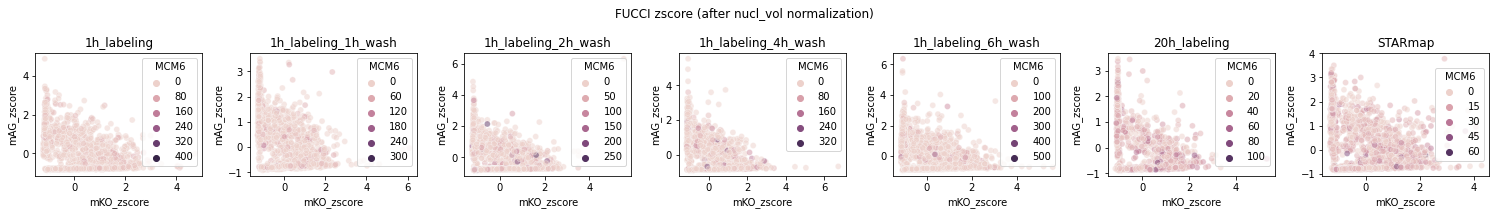

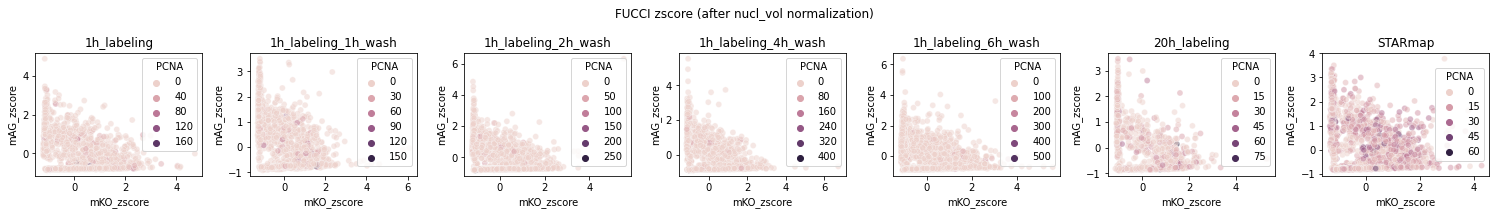

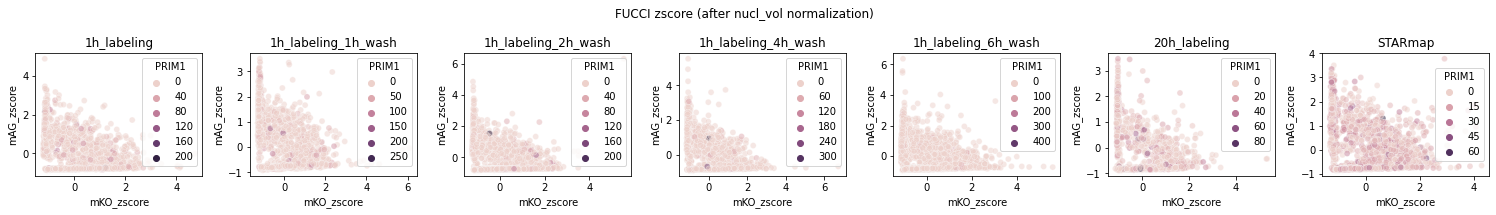

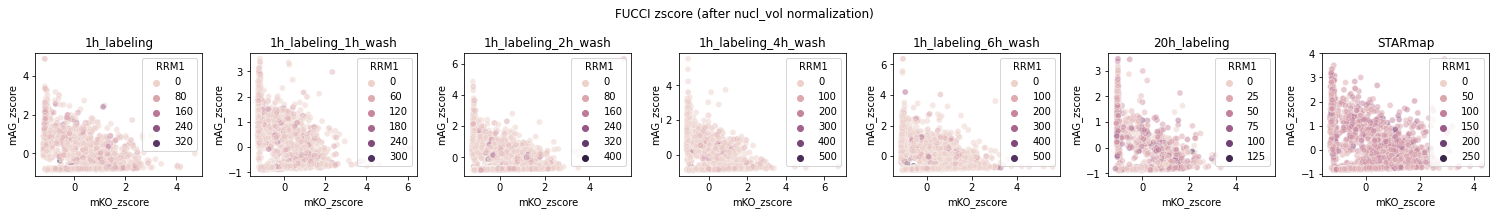

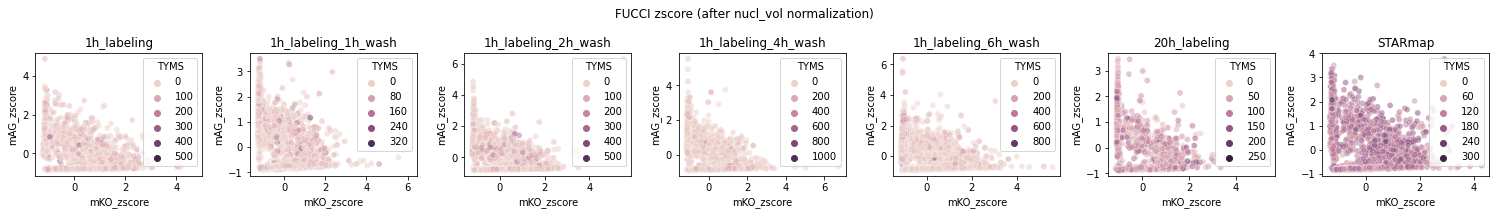

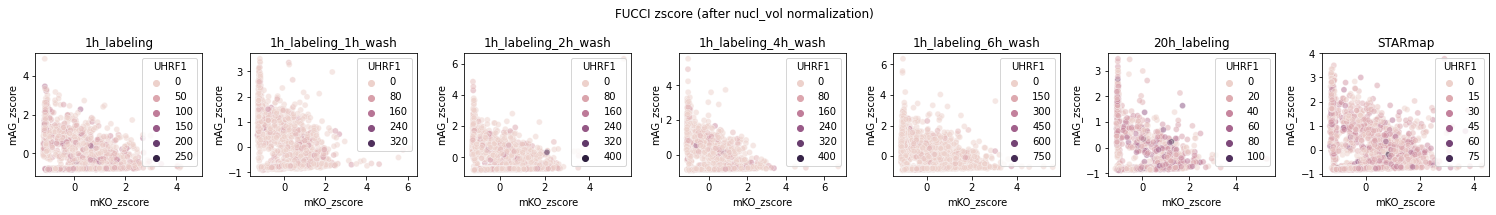

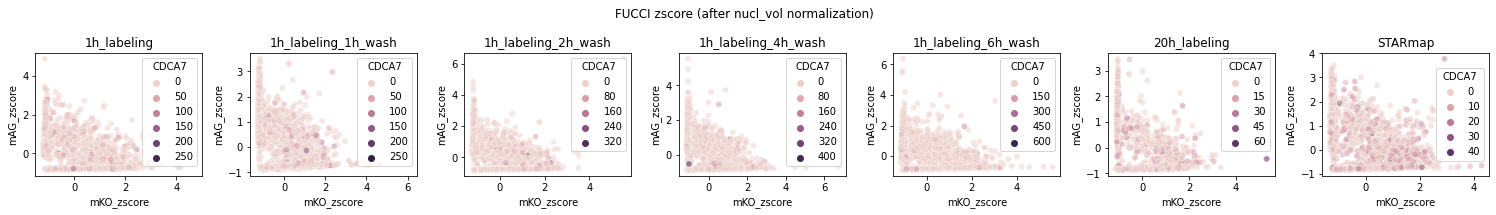

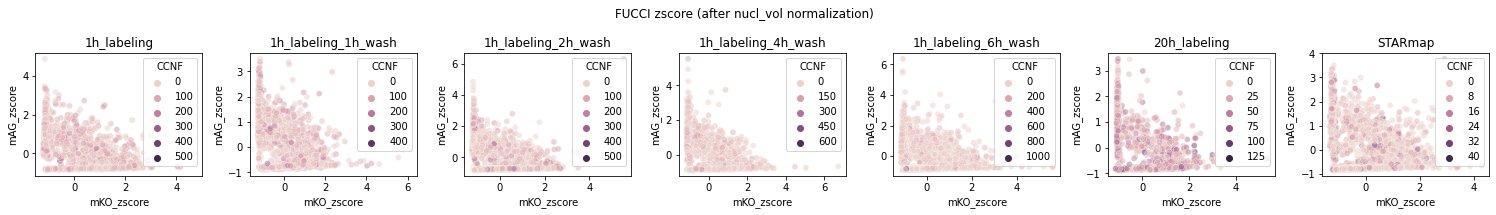

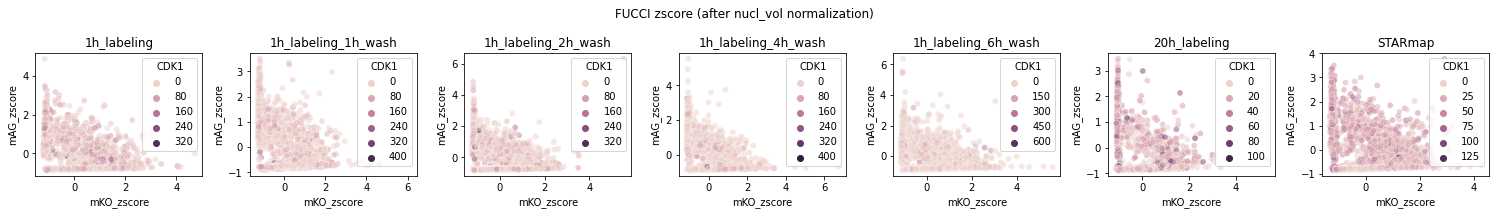

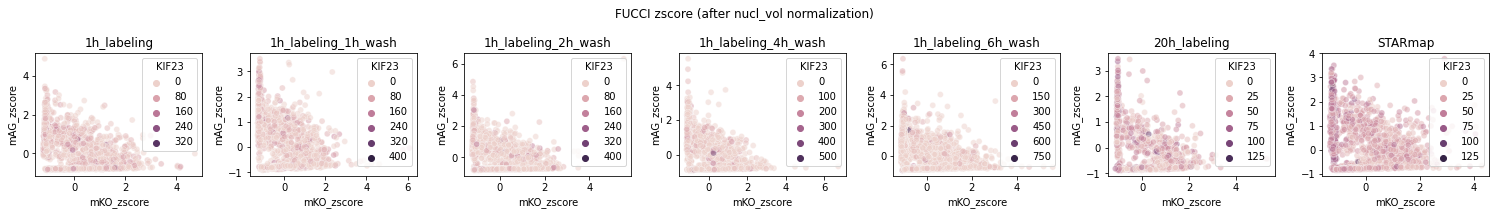

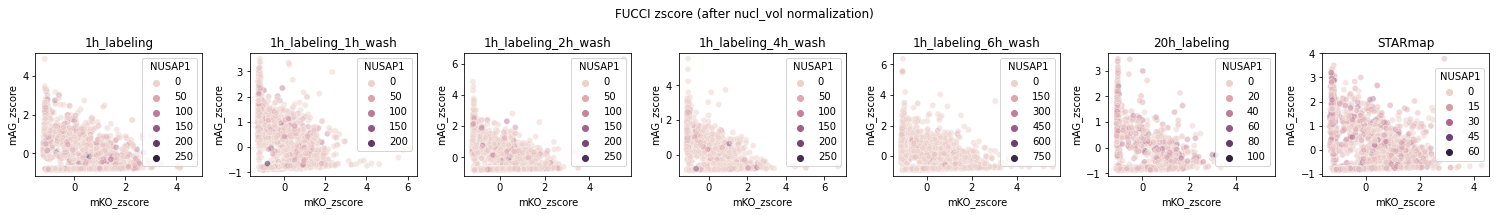

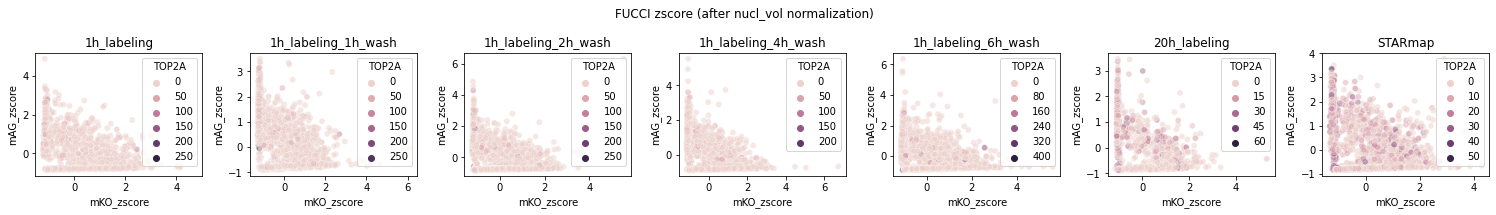

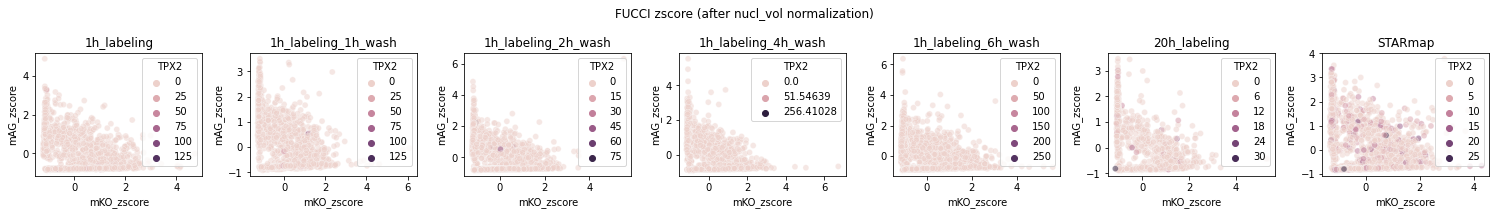

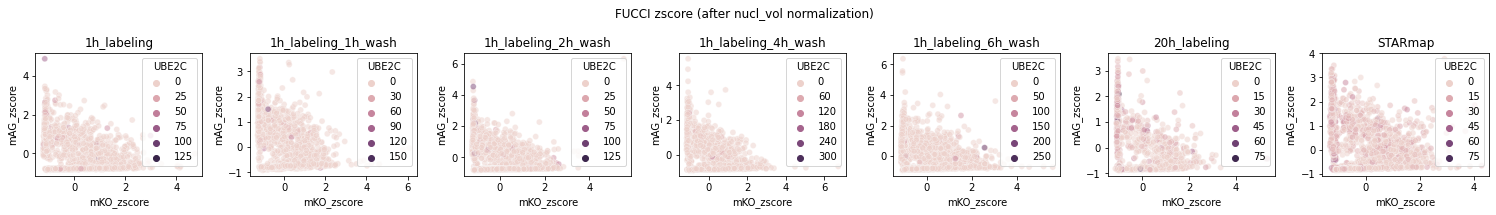

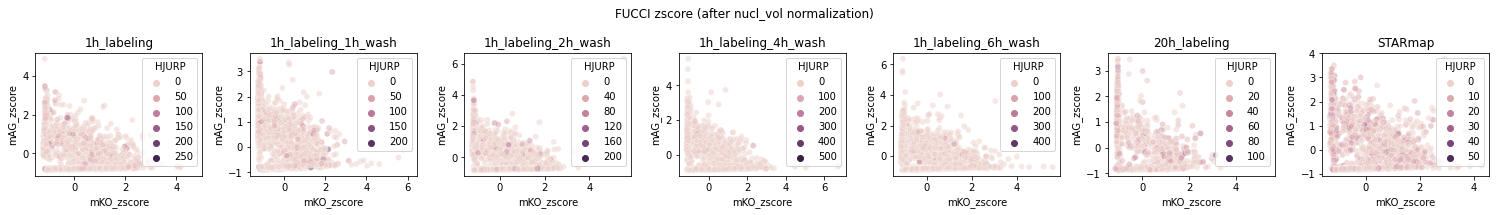

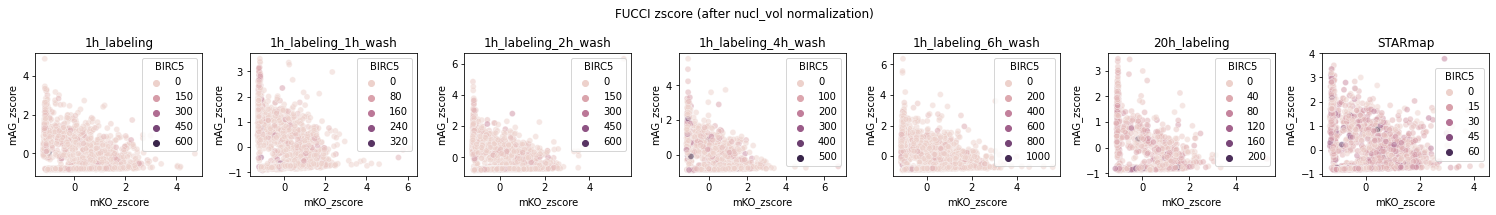

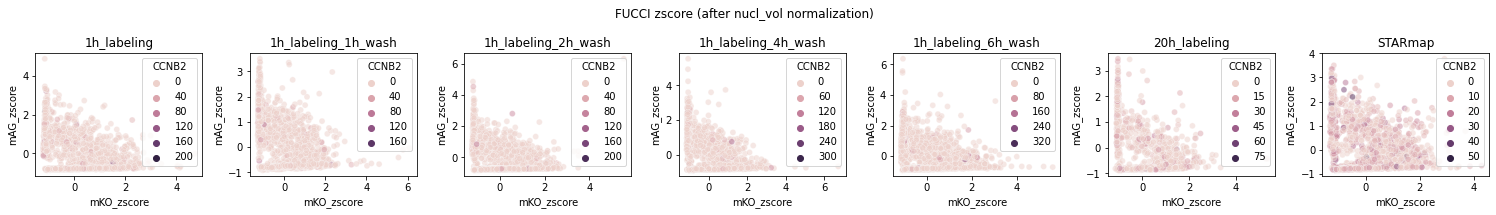

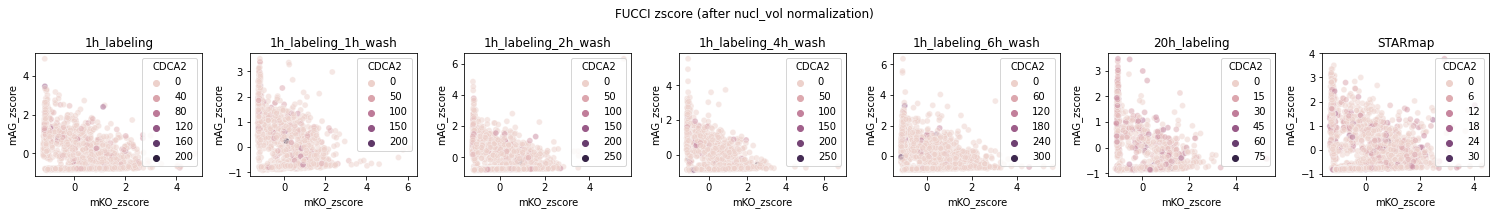

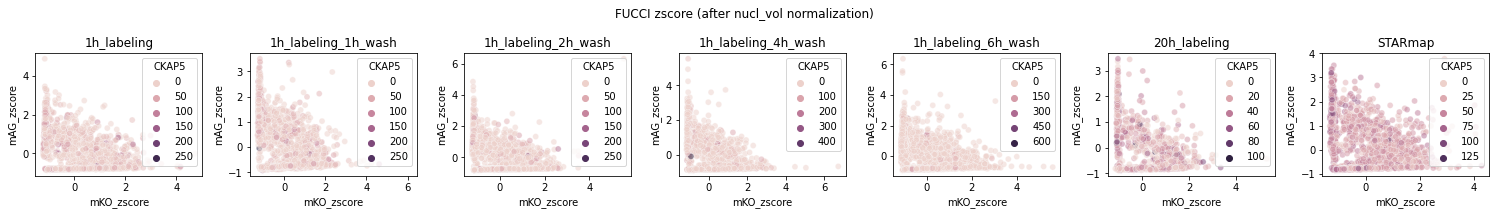

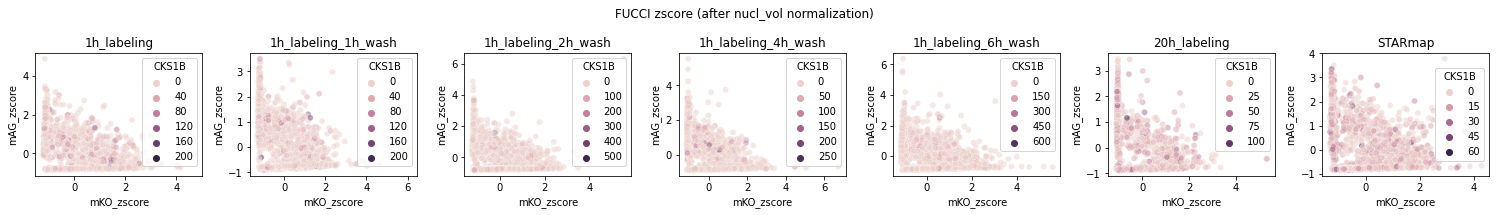

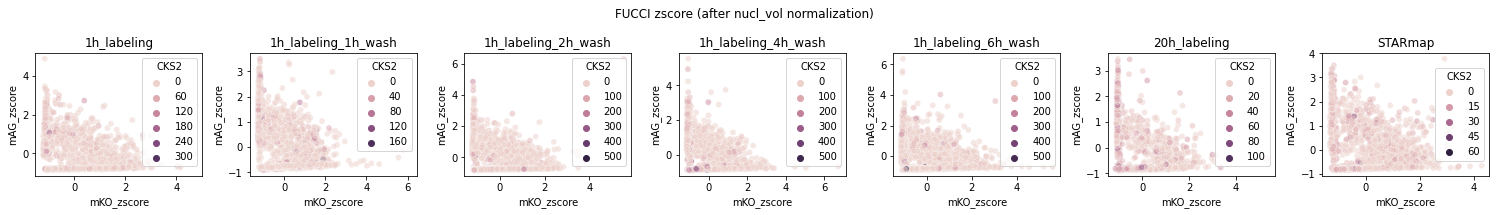

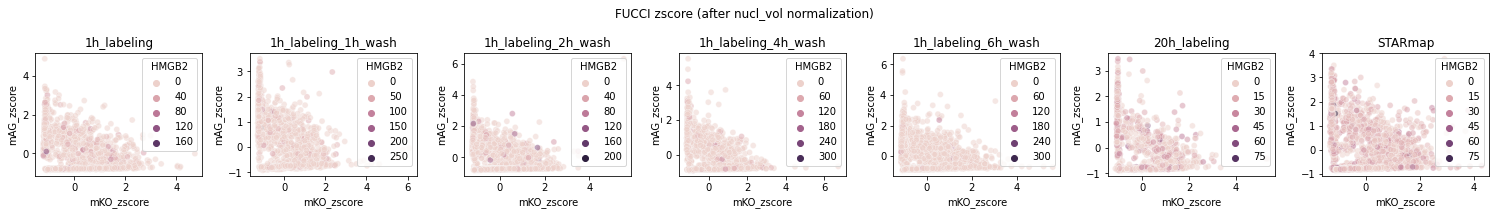

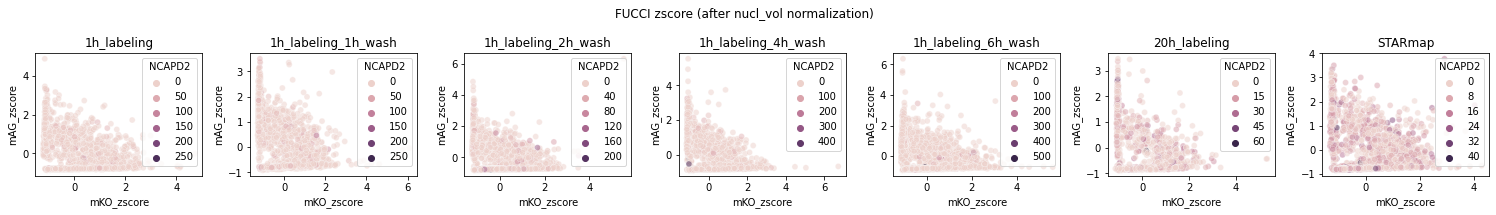

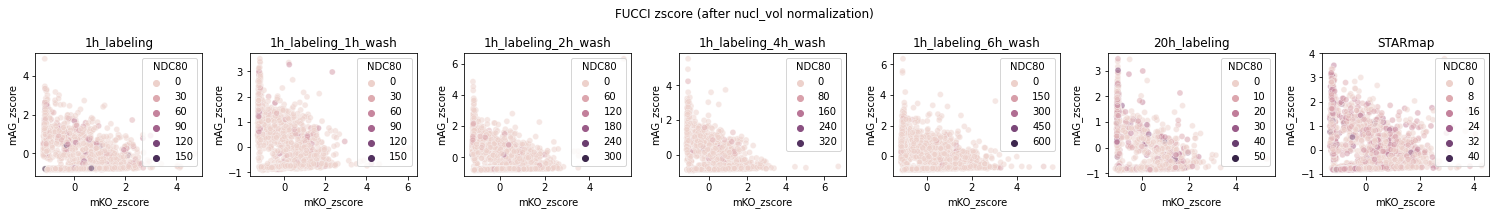

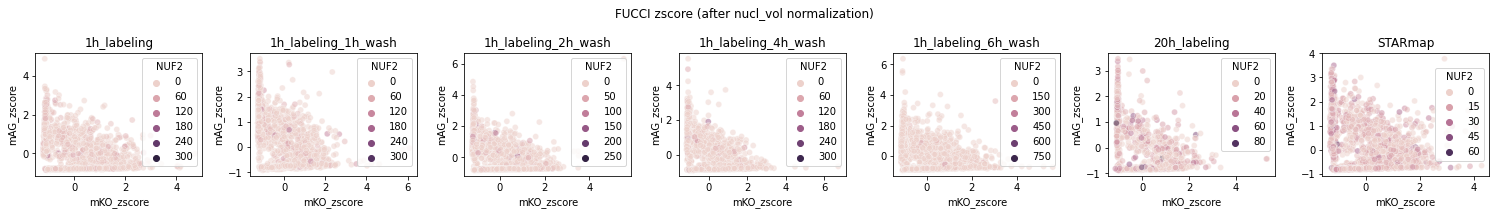

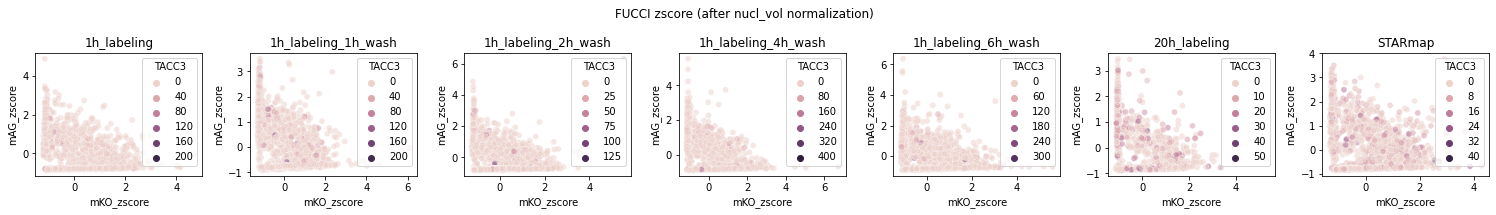

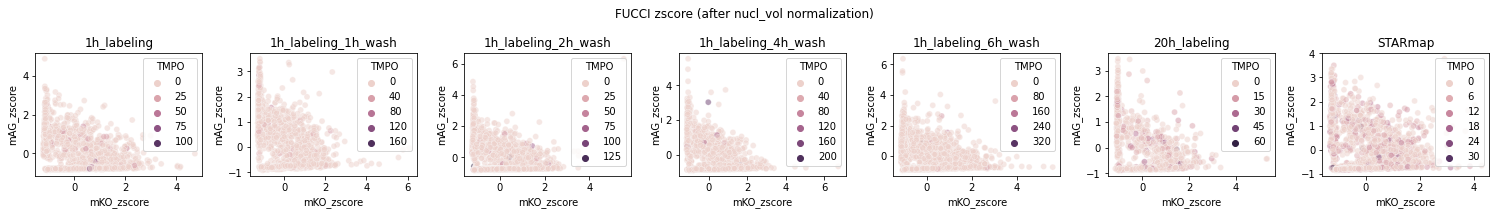

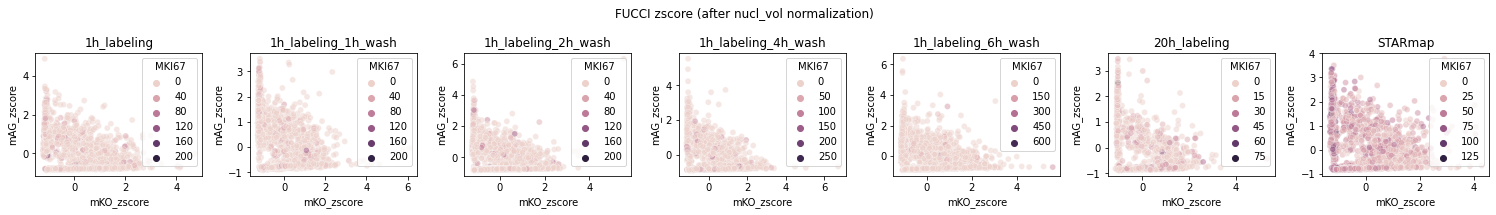

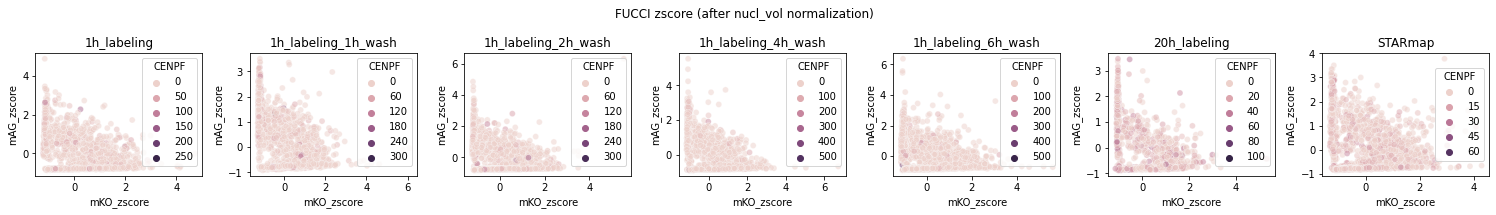

In [12]:
for marker in cell_cycle_genes:
    fig, ax = plt.subplots(1, n_samples, figsize=(3*n_samples,3))
    for j, sample in enumerate(sample_list):
        obs = copy(sample_adata[sample].obs)
        sample_adata[sample].obs['mKO_zscore'] = zscore(obs['mKO_norm'])
        sample_adata[sample].obs['mAG_zscore'] = zscore(obs['mAG_norm'])
        sns.scatterplot(data=sample_adata[sample].obs, x='mKO_zscore', y='mAG_zscore', hue=marker, ax=ax[j], alpha=0.5).set_title(sample)
    plt.suptitle('FUCCI zscore (after nucl_vol normalization)')
    plt.tight_layout()
    # break